# Correct the data

Correct the data with the help of COARE 3.6, we need to have winds at 10m, air temp at 2m etc.

## Import libraries

In [125]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import os
import pathlib
import geomag
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cmocean.cm as cmo
import sys
sys.path.append('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/notebooks/AirSeaFluxCode/')  # Add the current directory to the Python path
from AirSeaFluxCode import AirSeaFluxCode  # Import the AirSeaFluxCode module
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)

def fix_xticks(ax,ds):
    
    if  mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 2 :
        ax[0].xaxis.set_minor_locator(mdates.HourLocator(np.arange(0,24,6)))
        ax[0].xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,24)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(6,'H'),ds.time[-1] + np.timedelta64(6,'H'))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 2, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 7):
        ax[0].xaxis.set_minor_locator(mdates.HourLocator([0,12]))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(1,'D'),ds.time[-1] + np.timedelta64(1,'D'))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 7, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 15):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(2,32,2)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        ax[-1].set_xlabel('2023')
        ax[0].set_xlim(ds.time[0] - np.timedelta64(1,'D'),ds.time[-1] + np.timedelta64(1,'D'))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 15, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 30):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator([5,10,15,20,25,30]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        #ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(2,'D'),ds.time[-1] + np.timedelta64(2,'D'))

    if  mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 30:
        ax[0].xaxis.set_major_locator(mdates.MonthLocator())
        ax[0].xaxis.set_minor_locator(mdates.DayLocator([1,5,10,15,20,25]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%B"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(3,'D'),ds.time[-1] + np.timedelta64(3,'D'))

    rot_ticks(ax[-1],0,'center')
    ax[0].set_xlabel('')

def gridlines(ax,lon_tick,lat_tick,top=False,bottom=True,left=True,right=False):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = top
    gl.bottom_labels = bottom
    gl.right_labels = right
    gl.left_labels = left
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 24}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1


wgc = 'C1'
kc = '#006699'
sdc = '#ff6600'
ppc = 'crimson'
sc = 'goldenrod'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Import data

In [2]:
sbs = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/kringla_sochic.nc')
sbk = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/kringla_quicche.nc')
sbpp1 = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/pimpim_quicche_first.nc')
sbpp = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/pimpim_quicche_full.nc')
ship = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche.nc')      # Ship data, 1 minute

## 2. Corrections

### 2.1. Sailbuoy

#### 2.1.1. Kringla

In [3]:
# Convert Sailbuoy data into NumPy arrays
lat  = np.asarray(sbk["latitude"])      # Latitude - As recorded by the Sailbuoy
spd  = np.asarray(sbk["wind_speed"])    # Wind speed - As measured by the Sailbuoy
t    = np.asarray(sbk["air_temp"])      # Air temperature - As measured by the Sailbuoy
sst  = np.asarray(sbk["sst"])           # Sea surface temperature - As measured by the Sailbuoy

# Initialize a constant
hin  = 0.3  # Height of the sensors

# Calculate temperature at 2 meters above the sea surface, as the input ´hout´ is = 2, despite the ´out_var´ being = 't10n'
t2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                   t, 
                                   sst, 
                                   "skin", 
                                   meth = "C35", 
                                   lat = lat, 
                                   hin = 0.3, 
                                   hout = 2,
                                   out_var = ["t10n"])

# Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
u10n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                    t, 
                                    sst, 
                                    "skin", 
                                    meth = "C35", 
                                    lat = lat, 
                                    hin = 0.3, 
                                    hout = 10,
                                    out_var = ["u10n"])

# Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
sbk['t2m'] = ('time'), t2n['t10n'] - 273.15

# Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
sbk['u10'] = ('time'), u10n['u10n']

# Assign some flags or indicators to the 'flags' column
sbk['flags'] = ('time'), u10n['flag']

#### 2.1.2. PimPim

In [4]:
# Convert Sailbuoy data into NumPy arrays
lat  = np.asarray(sbpp["latitude"])          # Latitude
spd  = np.asarray(sbpp["wind_speed"])        # Wind speed
t    = np.asarray(sbpp["air_t"])             # Air temperature
sst  = np.asarray(sbpp["sst"])               # Sea surface temperature
rh   = np.asarray(sbpp["rh"])                # Relative humidity

# Initialize a constant
hin  = 1  # Height of the sensors (1 meter)

# Calculate temperature at 2 meters above the sea surface ('t10n'), despite 'out_var' being 't10n'
t2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                     t, 
                                     sst, 
                                     "skin", 
                                     meth = "C35", 
                                     lat = lat, 
                                     hin = 1, 
                                     hout = 2,
                                     out_var = ["t10n"])

# Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
u10n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                     t, 
                                     sst, 
                                     "skin", 
                                     meth = "C35", 
                                     lat = lat, 
                                     hin = 1, 
                                     hout = 10,
                                     out_var = ["u10n"])

# Calculate specific humidity at 2 meters above the sea surface ('q10n') by considering relative humidity ('rh')
q2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                    t, 
                                    sst, 
                                    "skin", 
                                    meth = "C35", 
                                    lat = lat, 
                                    hin = 1, 
                                    hout = 2,
                                    hum=["rh", rh], 
                                    out_var = ["q10n"])

# Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
sbpp['t2m'] = ('time'), t2n['t10n'] - 273.15

# Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
sbpp['u10'] = ('time'), u10n['u10n']

# Assign the calculated specific humidity values at 2 meters above the sea surface (converted to g/kg) to the 'q2m' column
sbpp['q2m'] = ('time'), q2n['q10n']*1e3

# Assign some flags or indicators to the 'flags' column
sbpp['flags'] = ('time'), u10n['flag']





# Convert Sailbuoy data into NumPy arrays
lat  = np.asarray(sbpp1["latitude"])          # Latitude
spd  = np.asarray(sbpp1["wind_speed"])        # Wind speed
t    = np.asarray(sbpp1["air_t"])             # Air temperature
sst  = np.asarray(sbpp1["sst"])               # Sea surface temperature
rh   = np.asarray(sbpp1["rh"])                # Relative humidity

# Initialize a constant
hin  = 1  # Height of the sensors (1 meter)

# Calculate temperature at 2 meters above the sea surface ('t10n'), despite 'out_var' being 't10n'
t2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                     t, 
                                     sst, 
                                     "skin", 
                                     meth = "C35", 
                                     lat = lat, 
                                     hin = 1, 
                                     hout = 2,
                                     out_var = ["t10n"])

# Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
u10n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                     t, 
                                     sst, 
                                     "skin", 
                                     meth = "C35", 
                                     lat = lat, 
                                     hin = 1, 
                                     hout = 10,
                                     out_var = ["u10n"])

# Calculate specific humidity at 2 meters above the sea surface ('q10n') by considering relative humidity ('rh')
q2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                    t, 
                                    sst, 
                                    "skin", 
                                    meth = "C35", 
                                    lat = lat, 
                                    hin = 1, 
                                    hout = 2,
                                    hum=["rh", rh], 
                                    out_var = ["q10n"])

# Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
sbpp1['t2m'] = ('time'), t2n['t10n'] - 273.15

# Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
sbpp1['u10'] = ('time'), u10n['u10n']

# Assign the calculated specific humidity values at 2 meters above the sea surface (converted to g/kg) to the 'q2m' column
sbpp1['q2m'] = ('time'), q2n['q10n']*1e3

# Assign some flags or indicators to the 'flags' column
sbpp1['flags'] = ('time'), u10n['flag']


### 2.2. Ship

In [5]:
# Convert ship data into NumPy arrays
lat  = np.asarray(ship["LA"])               # Latitude
spd  = np.asarray(ship["TW"])               # Wind speed
t    = np.asarray(ship["RT"])               # Air temperature
sst  = np.asarray(ship["TT"])               # Sea surface temperature
rh   = np.asarray(ship["RH"])               # Relative humidity

# Initialize a constant
hin  = 17  # Height of the sensors (17 meters)

# Calculate temperature at 2 meters above the sea surface ('t10n')
t2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                     t, 
                                     sst, 
                                     "skin", 
                                     meth = "C35", 
                                     lat = lat, 
                                     hin = 17, 
                                     hout = 2,
                                     out_var = ["t10n"])

# Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
u10n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                     t, 
                                     sst, 
                                     "skin", 
                                     meth = "C35", 
                                     lat = lat, 
                                     hin = 17, 
                                     hout = 10,
                                     out_var = ["u10n"])

# Calculate specific humidity at 2 meters above the sea surface ('q10n') by considering relative humidity ('rh')
q2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                    t, 
                                    sst, 
                                    "bulk", 
                                    meth = "UA", 
                                    lat = lat, 
                                    hin = 17, 
                                    hout = 2,
                                    hum=["rh", rh], 
                                    out_var = ["q10n"])

# Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
ship['t2m'] = ('time'), t2n['t10n'] - 273.15

# Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
ship['u10'] = ('time'), u10n['u10n']

# Assign the calculated specific humidity values at 2 meters above the sea surface (converted to g/kg) to the 'q2m' column
ship['q2m'] = ('time'), q2n['q10n']*1e3

# Assign some flags or indicators to the 'flags' column
ship['flags'] = ('time'), u10n['flag']

### 2.3. Waveglider

In [6]:
import pandas as pd
import glob
from datetime import datetime

wg_files = glob.glob('/Users/xedhjo/Documents/Projects/QUICCHE/data/waveglider/2023*.csv')
wg_files.sort()

ds = pd.concat((pd.read_csv(filename) for filename in wg_files), ignore_index=True)

date=[]

for i in range (len(ds.Datetime)):
    
    datetime_str = ds.Datetime[i]
    
    try:
        dateobject = pd.to_datetime(ds.Datetime[i])
        date.append(np.datetime64(dateobject))
    except:
        date.append(np.nan)
    
ds['time'] = np.array(date)
ds = ds.sort_values('time').drop_duplicates('time').set_index('time').to_xarray().sel(time='2023').resample(time='10min').mean()

def parseGPS(sxGPS):    ## CALCULATE SUBSURFACE LAT / LON (TODO: USING DEAD RECKONING)
    return np.sign(sxGPS) * (np.fix(np.abs(sxGPS)/100) + np.mod(np.abs(sxGPS),100)/60)

ds['longitude'] = ('time'), parseGPS(ds['Longitude'].values)
ds['latitude'] = ('time'), parseGPS(ds['Latitude'].values)

In [7]:
# Helper function to calculate distance
def calculate_distance(ds1, ds2, lat1, lat2, lon1, lon2):

    dist = ds1[lat1].copy() * np.nan
    
    for i,t in enumerate(ds1.time.values):
        if t in ds2.time:
            dist[i] = (gsw.distance([ds1[lon1].sel(time=t), ds2[lon2].sel(time=t)], [ds1[lat1].sel(time=t), ds2[lat2].sel(time=t)])[0] / 1000)
    return dist.interpolate_na('time').values

In [8]:
sbk['distance_to_wg']    = ('time'), calculate_distance(sbk,ds,'latitude', 'latitude', 'longitude', 'longitude')
sbk['distance_to_pp']    = ('time'), calculate_distance(sbk,sbpp,'latitude', 'latitude', 'longitude', 'longitude')
sbk['distance_to_ship']  = ('time'), calculate_distance(sbk,ship,'latitude', 'LA', 'longitude', 'LO')

ds['distance_to_sbk']    = ('time'), calculate_distance(ds,sbk,'latitude', 'latitude', 'longitude', 'longitude')
ds['distance_to_pp']     = ('time'), calculate_distance(ds,sbpp,'latitude', 'latitude', 'longitude', 'longitude')
ds['distance_to_ship']   = ('time'), calculate_distance(ds,ship,'latitude', 'LA', 'longitude', 'LO')

sbpp['distance_to_wg']   = ('time'), calculate_distance(sbpp,ds,'latitude', 'latitude', 'longitude', 'longitude')
sbpp['distance_to_sbk']  = ('time'), calculate_distance(sbpp,sbk,'latitude', 'latitude', 'longitude', 'longitude')
sbpp['distance_to_ship'] = ('time'), calculate_distance(sbpp,ship,'latitude', 'LA', 'longitude', 'LO')

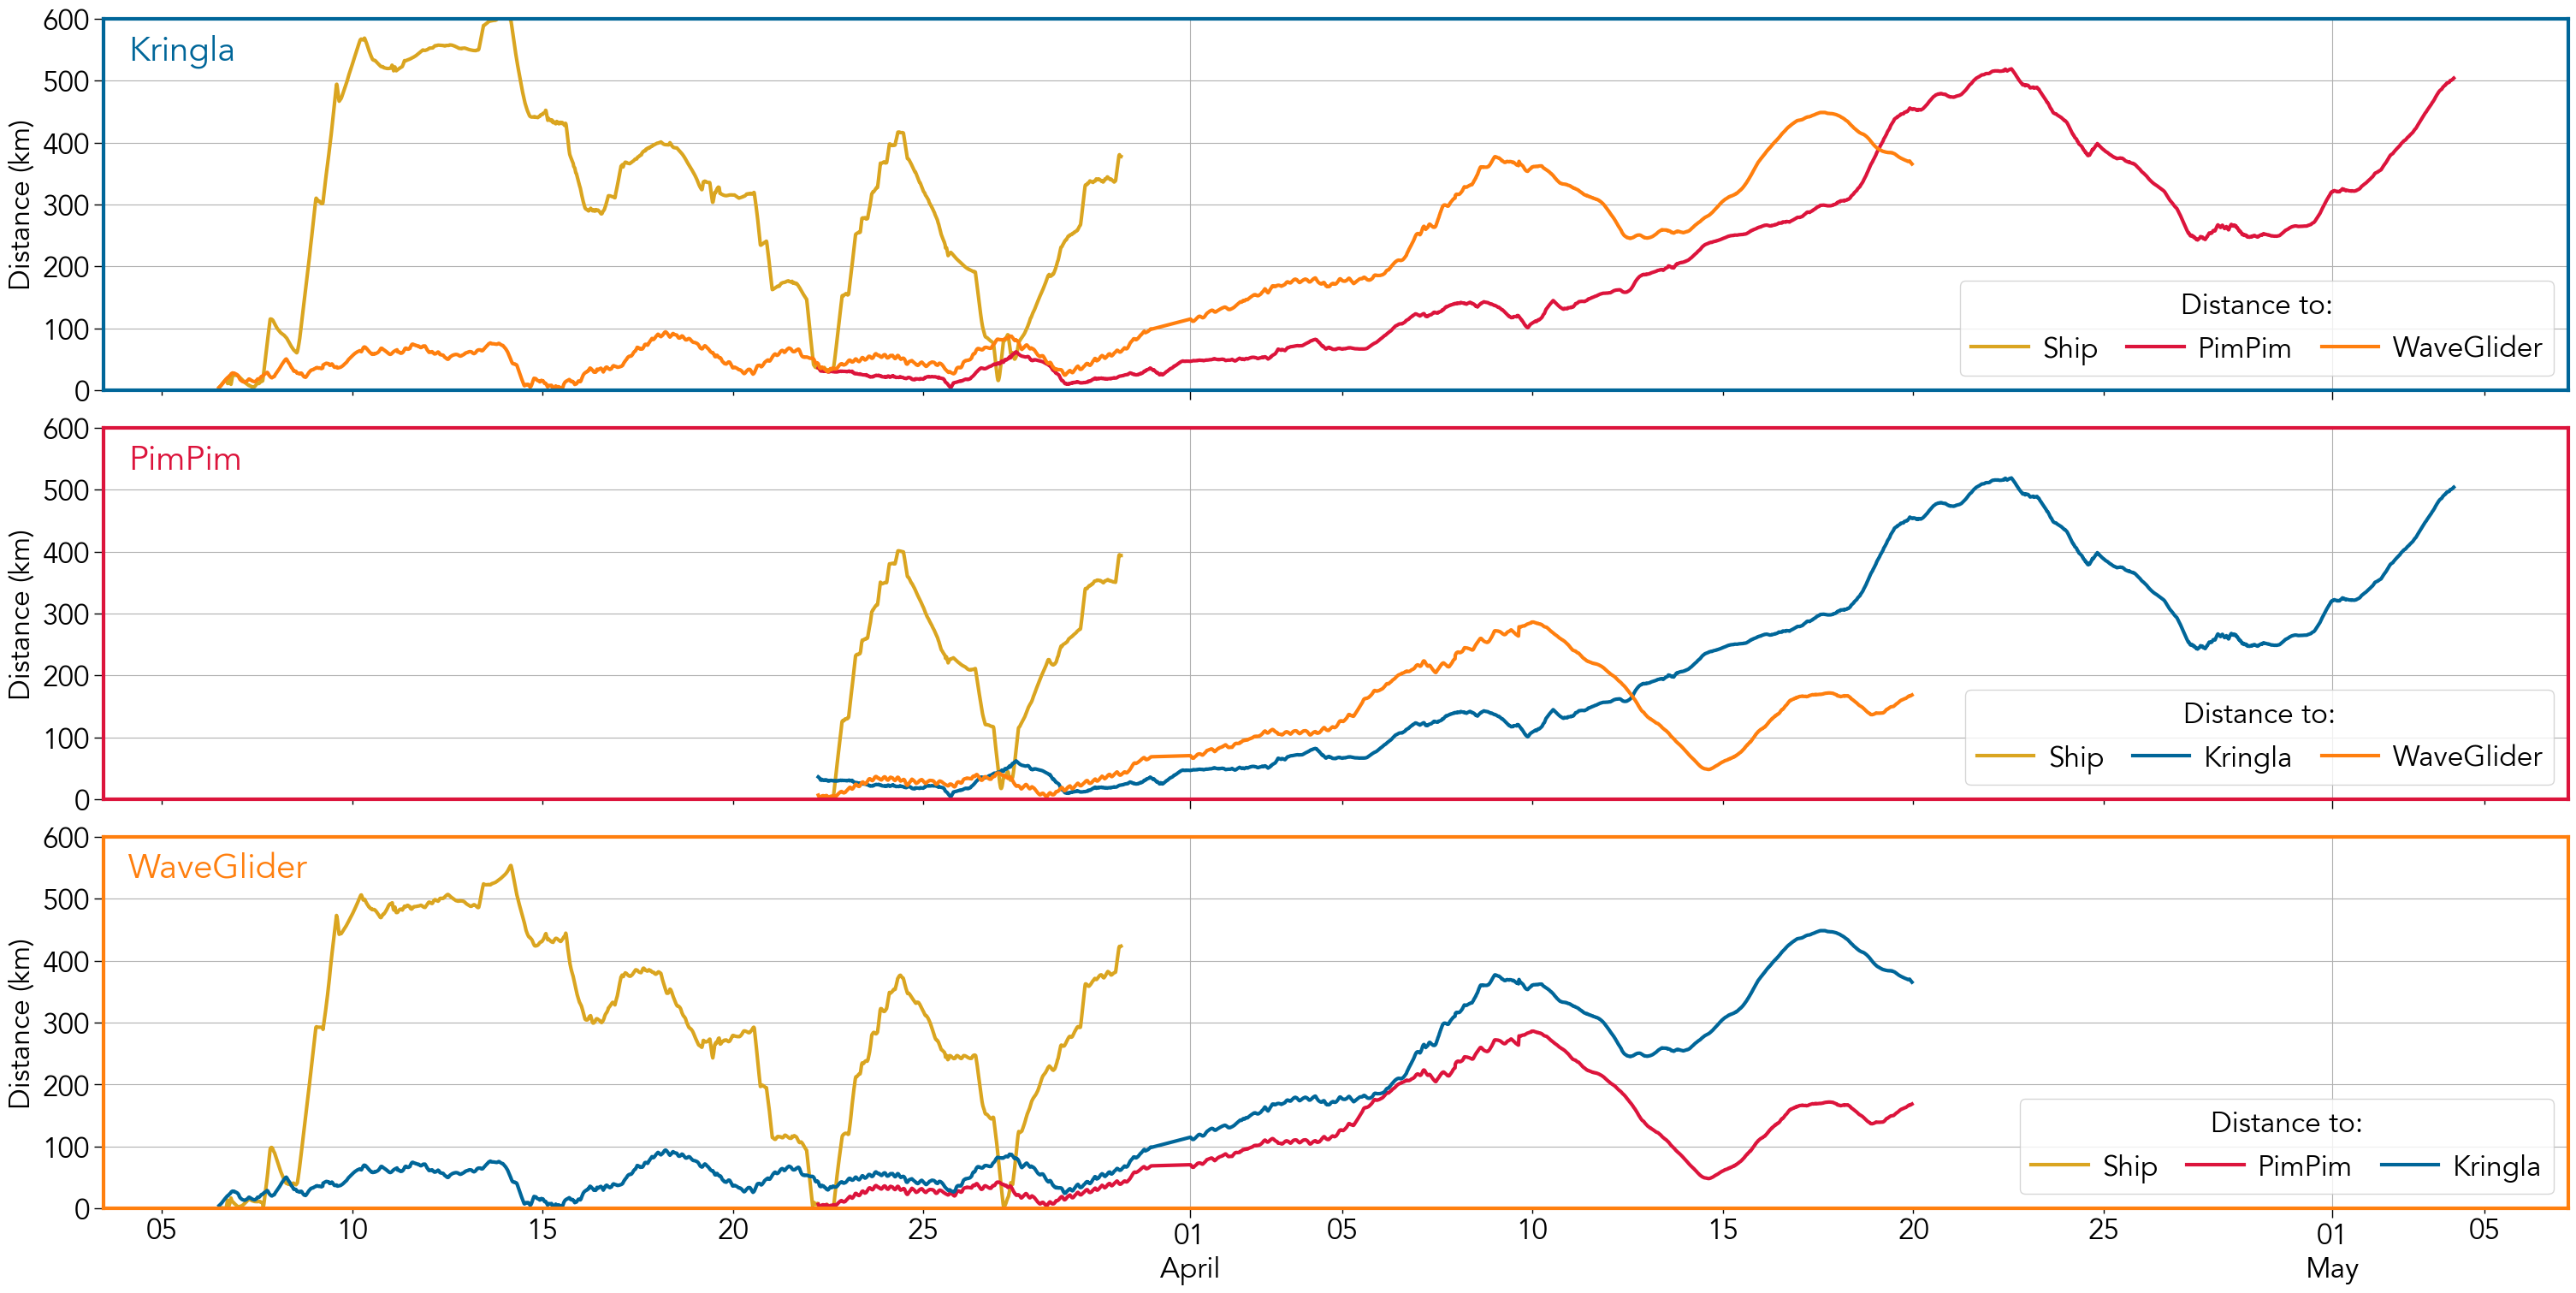

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (30,15), sharex = True, constrained_layout=True)

sbk['distance_to_ship'].plot(ax=ax[0], lw=3, c='goldenrod', label = 'Ship')
sbk['distance_to_pp'].plot(ax=ax[0], lw=3, c=ppc, label = 'PimPim')
sbk['distance_to_wg'].plot(ax=ax[0], lw=3, c='C1', label = 'WaveGlider')

sbpp['distance_to_ship'].plot(ax=ax[1], lw=3, c='goldenrod', label = 'Ship')
sbpp['distance_to_sbk'].plot(ax=ax[1], lw=3, c=kc, label = 'Kringla')
sbpp['distance_to_wg'].plot(ax=ax[1], lw=3, c='C1', label = 'WaveGlider')

ds['distance_to_ship'].plot(ax=ax[2], lw=3, c='goldenrod', label = 'Ship')
ds['distance_to_pp'].plot(ax=ax[2], lw=3, c=ppc, label = 'PimPim')
ds['distance_to_sbk'].plot(ax=ax[2], lw=3, c=kc, label = 'Kringla')

for i,axs in enumerate(ax):
    axs.set(ylabel='Distance (km)', xlabel='', yticks=np.arange(0,610,100), ylim=(0,600))
    axs.legend(loc = 'lower right',
               ncol = 3, 
               title = 'Distance to:', 
               columnspacing = 1,
               handletextpad = 0.5)
    axs.grid()
    axs.set_title(['Kringla','PimPim','WaveGlider'][i], loc='left', y=0.87, x=0.01, c=[kc,ppc,'C1'][i], fontweight='bold')
    
for axs, c in zip(ax,[kc, ppc, wgc]):
    for place in ['top','bottom','left','right']:
        axs.spines[place].set_color(c)
        axs.spines[place].set_linewidth(3)
    

fix_xticks(ax,sbk)

In [10]:
from datetime import datetime 
wg_weather = pd.read_csv('/Users/xedhjo/Documents/Projects/QUICCHE/data/WG_met_subset_20230319.csv')

date=[]
for i in range (len(wg_weather.TimeStamp)):
    datetime_str = wg_weather.TimeStamp[i]

    dateobject = (datetime.strptime(datetime_str, '%m/%d/%Y %H:%M:%S'))
    date.append(np.datetime64(dateobject))
    
wg_weather['time'] = np.array(date)

wg_weather['Wind_Speed']=wg_weather['Wind Speed(kt)']*0.51444 
wg_weather['Wind Direction'] = (wg_weather['Wind Direction']+ 180) % 360

In [11]:
wg_weather = wg_weather.sort_values('time').drop_duplicates('time').set_index('time').to_xarray()
sbk_wg = sbk.sel(time=wg_weather.time.values.astype('datetime64[s]'))

In [12]:
wg_weather = wg_weather[['Temperature(degC)','Wind_Speed','Wind Direction','Latitude','Longitude']].rename({'Temperature(degC)':'air_t', 'Wind_Speed':'wind_speed', 'Wind Direction': 'wind_dir', 'Latitude':'latitude','Longitude':'longitude'})

wg_weather['time'] = wg_weather['time'] - np.timedelta64(2, 'h')

wg = ds[['CTD Temp','CTD Conductivity', 'Ocean CO2 Ave', 'Atmosphere CO2 Ave','distance_to_sbk','distance_to_pp','distance_to_ship']].rename({'CTD Temp':'sst', 'CTD Conductivity':'ssc', 'Ocean CO2 Ave':'co2oce', 'Atmosphere CO2 Ave':'co2atm'})

wg['time'] = wg['time'] - np.timedelta64(2, 'h')

wg = xr.merge([wg_weather,wg.sel(time=wg_weather.time)])

wg = wg.interpolate_na('time')

In [13]:
# Convert Sailbuoy data into NumPy arrays
lat  = np.asarray(wg["latitude"])      # Latitude - As recorded by the WG
spd  = np.asarray(wg["wind_speed"])    # Wind speed - As measured by the WG
t    = np.asarray(wg["air_t"])         # Air temperature - As measured by the WG
sst  = np.asarray(wg["sst"])           # Sea surface temperature - As measured by the WG

# Initialize a constant
hin  = 0.7  # Height of the sensors

# Calculate temperature at 2 meters above the sea surface, as the input ´hout´ is = 2, despite the ´out_var´ being = 't10n'
t2n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                   t, 
                                   sst, 
                                   "skin", 
                                   meth = "C35", 
                                   lat = lat, 
                                   hin = hin, 
                                   hout = 2,
                                   out_var = ["t10n"])

# Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
u10n = AirSeaFluxCode.AirSeaFluxCode(spd, 
                                    t, 
                                    sst, 
                                    "skin", 
                                    meth = "C35", 
                                    lat = lat, 
                                    hin = hin, 
                                    hout = 10,
                                    out_var = ["u10n"])

# Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
wg['t2m'] = ('time'), t2n['t10n'] - 273.15

# Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
wg['u10'] = ('time'), u10n['u10n']

# Assign some flags or indicators to the 'flags' column
wg['flags'] = ('time'), u10n['flag']

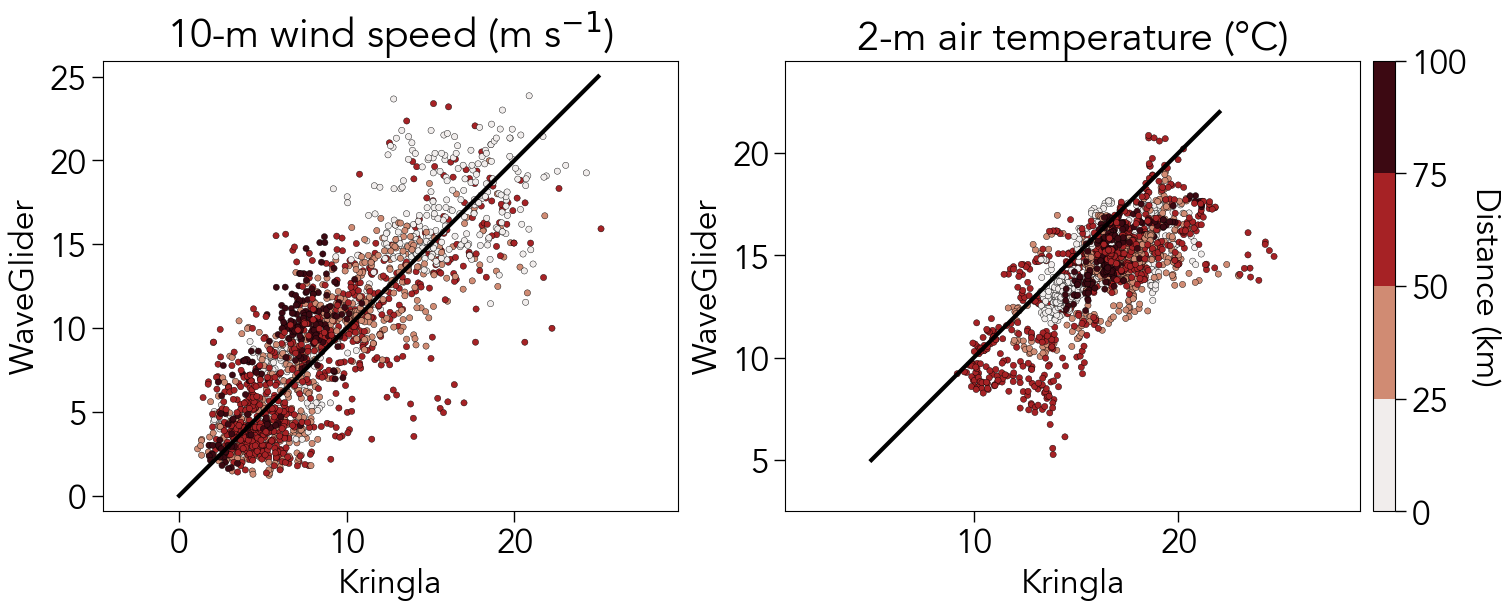

In [316]:
fig, (ax,bx) = plt.subplots(1,2,constrained_layout=True, figsize=(15,6))

vmax = 100
nbins = 4
cmaps = plt.get_cmap('cmo.amp',nbins)

sct = ax.scatter(sbk_wg['u10'],wg['u10'], 20, sbk_wg['distance_to_wg'], cmap = cmaps, ec = 'k', vmin=0, vmax=vmax, lw=0.3)
sct = bx.scatter(sbk_wg['t2m'],wg['t2m'], 20, sbk_wg['distance_to_wg'], cmap = cmaps, ec = 'k', vmin=0, vmax=vmax, lw=0.3)

ax.plot([0,25],[0,25], c='k', lw=3)
bx.plot([5,22],[5,22], c='k', lw=3)

cb = plt.colorbar(sct,ax=[ax,bx], pad=0.01)
cb.set_ticks(np.arange(0, vmax+1, int(vmax/nbins)))
cb.set_label('Distance (km)', rotation=270, labelpad=25)

ylabels = ['WaveGlider', 'WaveGlider']
xlabels = ['Kringla', 'Kringla']
titles = ['10-m wind speed (m s$^{-1}$)', '2-m air temperature (°C)']

for axs,x,y,t in zip([ax,bx], xlabels, ylabels, titles):
    axs.set(xlabel=x, ylabel=y, title=t)
    axs.axis('equal')


In [36]:
idx = np.where(sbk_wg['distance_to_wg'] < 20)[0]

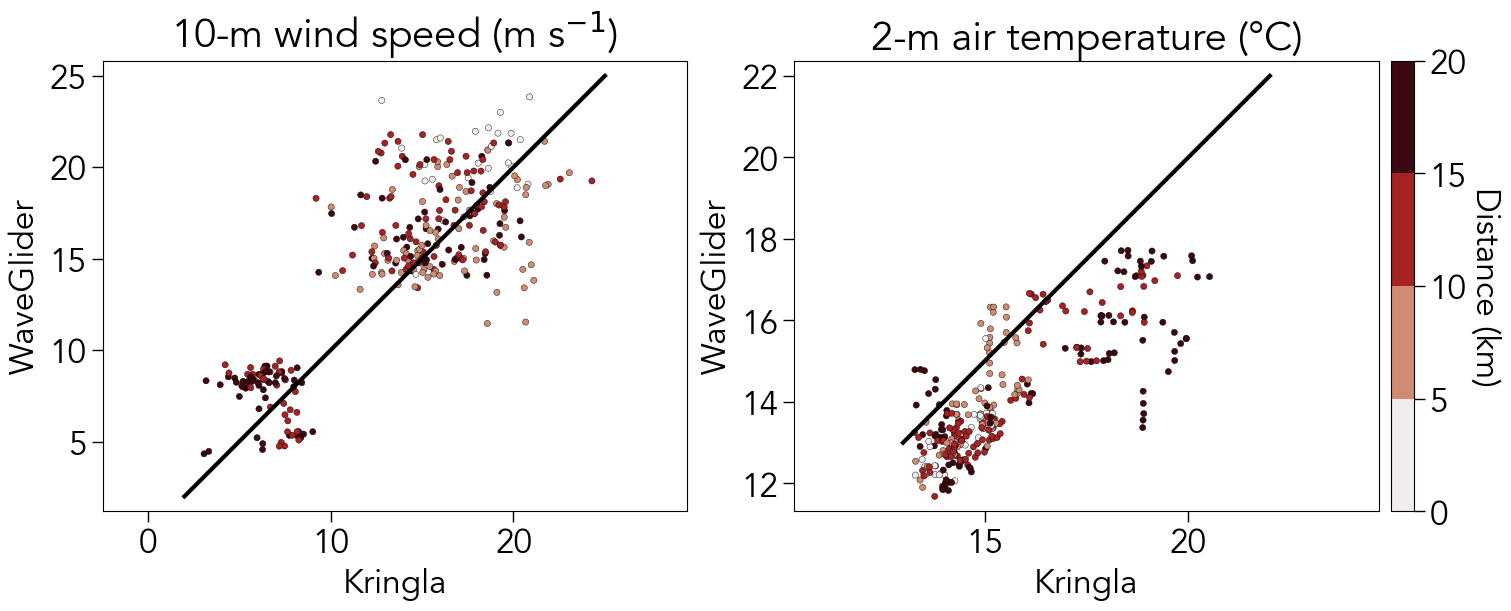

In [323]:
fig, (ax,bx) = plt.subplots(1,2,constrained_layout=True, figsize=(15,6))

vmax = 20
nbins = 4
cmaps = plt.get_cmap('cmo.amp',nbins)

sct = ax.scatter(sbk_wg['u10'][idx],wg['u10'][idx], 20, sbk_wg['distance_to_wg'][idx], cmap = cmaps, ec = 'k', vmin=0, vmax=vmax, lw=0.3)
sct = bx.scatter(sbk_wg['t2m'][idx],wg['t2m'][idx], 20, sbk_wg['distance_to_wg'][idx], cmap = cmaps, ec = 'k', vmin=0, vmax=vmax, lw=0.3)

ax.plot([2,25],[2,25], c='k', lw=3)
bx.plot([13,22],[13,22], c='k', lw=3)

cb = plt.colorbar(sct,ax=[ax,bx], pad=0.01)
cb.set_ticks(np.arange(0, vmax+1, int(vmax/nbins)))
cb.set_label('Distance (km)', rotation=270, labelpad=25)

ylabels = ['WaveGlider', 'WaveGlider']
xlabels = ['Kringla', 'Kringla']
titles = ['10-m wind speed (m s$^{-1}$)', '2-m air temperature (°C)']

for axs,x,y,t in zip([ax,bx], xlabels, ylabels, titles):
    axs.set(xlabel=x, ylabel=y, title=t)
    axs.axis('equal')

In [58]:
mt = [time for time in wg.time.values if time in sbk.time.values]
mi = [np.where(sbk.time.values == time)[0][0] for time in mt]
wgsb = wg.sel(time=mt)
wgsb = wgsb.rename(dict(t2m = 't2m_wg', u10 = 'u10_wg', latitude = 'lat_wg', longitude = 'lon_wg'))
wgsb['t2m_sbk'] = sbk.isel(time=mi)['t2m']
wgsb['u10_sbk'] = sbk.isel(time=mi)['u10']
wgsb['lat_sbk'] = sbk.isel(time=mi)['latitude']
wgsb['lon_sbk'] = sbk.isel(time=mi)['longitude']
wgsb['sss_sbk'] = sbk.isel(time=mi)['sss']
wgsb['sst_sbk'] = sbk.isel(time=mi)['sst']

In [15]:
from prettytable import PrettyTable
from IPython.display import display_html

def calculate_rmse_bias(data, variable1, variable2, wind_speed_ranges, title, distance):
    # Create an empty table with column headers
    table = PrettyTable()
    table.field_names = ["Wind Speed Range", "RMSE", "Bias", "n"]

    # Calculate RMSE and bias for each wind speed range and add it to the table
    for speed_range in wind_speed_ranges:
        min_speed, max_speed = speed_range
        subset = data.where(
            np.logical_and.reduce([
                data['u10_wg'] >= min_speed,
                data['u10_wg'] < max_speed,
                data['distance_to_sbk'] < distance  # Added condition for distance < 100 km
            ])
        )
        rmse = calc_rmse(subset[variable1] - subset[variable2]).values.round(2)
        bias = calc_bias(subset[variable1] - subset[variable2]).values.round(2)
        n = np.isfinite(subset[variable1]).sum().values  # Count non-NaN rows
        table.add_row([f"{min_speed}-{max_speed}", rmse, bias, n])

    # Calculate RMSE and bias for the whole dataset (total row) with distance < 100 km
    total_subset = data.where(data['distance_to_sbk'] < distance)
    total_rmse = calc_rmse(total_subset[variable1] - total_subset[variable2]).values.round(2)
    total_bias = calc_bias(total_subset[variable1] - total_subset[variable2]).values.round(2)
    total_n = np.isfinite(total_subset[variable1]).sum().values  # Count non-NaN rows
    table.add_row([f"Total (Distance < {distance} km)", total_rmse, total_bias, total_n])

    # Print the title
    print(title)

    # Print the table as an HTML table in Jupyter Lab
    display_html(table.get_html_string(), raw=True)

In [16]:
def calc_bias(ds):
    return ds.mean('time')
def calc_rmse(ds):
    return np.sqrt(np.mean(np.square(ds)))

In [46]:
# Example usage:
calculate_rmse_bias(wgsb, 't2m_wg', 't2m_sbk', [(0, 5), (5, 10), (10, 15), (15, 20)], "RMSE and Bias for Air temperature (°C)", 20)
calculate_rmse_bias(wgsb, 'u10_wg', 'u10_sbk', [(0, 5), (5, 10), (10, 15), (15, 20)], "RMSE and Bias for Wind speed (m/s)", 20)

RMSE and Bias for Air temperature (°C)


Wind Speed Range,RMSE,Bias,n
0-5,3.7,-3.5,7
5-10,2.08,-1.8,75
10-15,1.39,-1.23,55
15-20,1.38,-1.17,130
Total (Distance < 20 km),1.67,-1.42,312


RMSE and Bias for Wind speed (m/s)


Wind Speed Range,RMSE,Bias,n
0-5,1.86,-1.63,7
5-10,2.27,1.21,75
10-15,2.09,-0.4,55
15-20,2.99,0.72,130
Total (Distance < 20 km),2.94,1.01,312


In [17]:
wgsb_1h = wgsb.reset_coords().resample(time='1H').mean()

In [18]:
def customize_axis_color(ax, c, x=True):
    """
    Customize the color of the x-axis elements.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to customize.
        tick_color (str): Color for x-axis ticks.
        ticklabel_color (str): Color for x-axis tick labels.
        label_color (str): Color for x-axis label.

    Returns:
        None
    """
    if x:
        ax.xaxis.set_tick_params(color=c)  # Set tick color
        ax.tick_params(axis='x', colors=c)  # Set tick label color
        ax.set_xlabel(ax.get_xlabel(), color=c)  # Set label color
        ax.spines['bottom'].set_color(c) 
        ax.spines['bottom'].set_linewidth(2) 
    else:
        ax.yaxis.set_tick_params(color=c)  # Set tick color
        ax.tick_params(axis='y', colors=c)  # Set tick label color
        ax.set_ylabel(ax.get_ylabel(), color=c)  # Set label color
        ax.spines['left'].set_color(c)
        ax.spines['left'].set_linewidth(2) 


Text(0.5, 0.98, 'Kringla comparison with Wave Glider')

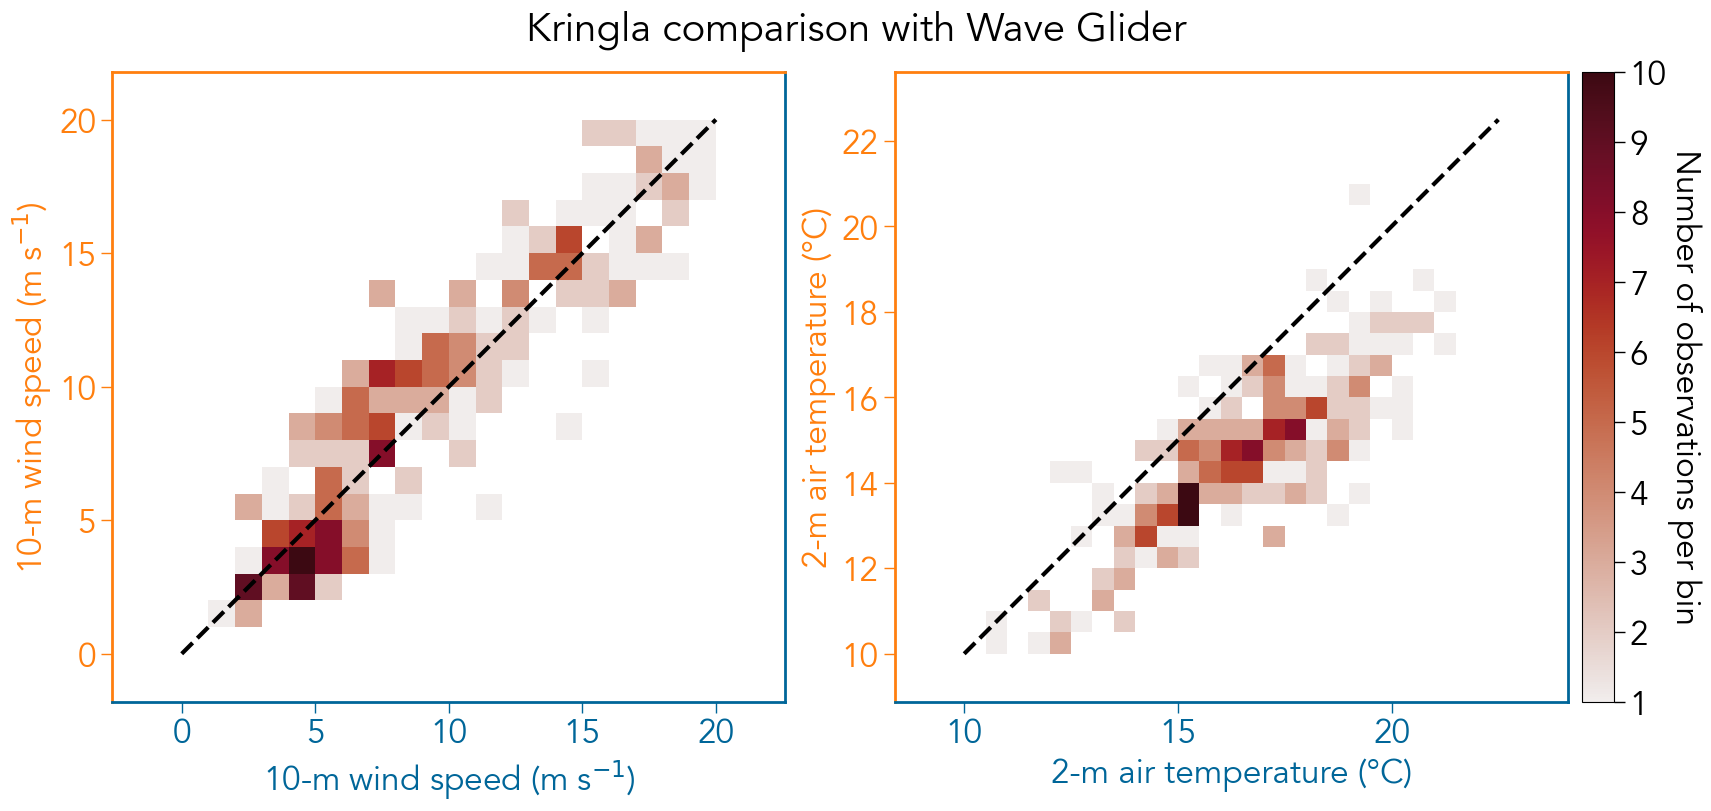

In [19]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(17,8))

varx = ['u10_sbk','t2m_sbk']
vary = ['u10_wg','t2m_wg']
bins = [[np.arange(0,21,1),np.arange(0,21,1)],(np.arange(10,23,0.5),np.arange(10,23,0.5))]

labels = ['10-m wind speed (m s$^{-1}$)', '2-m air temperature (°C)']
lines = [[0,22],[9,22]]

for axs, label, line, vax, vay, c, bools, binss in zip(ax, labels, lines, varx, vary, [kc,wgc], [True,False], bins):
    
    h = axs.hist2d(wgsb_1h[vax], wgsb_1h[vay], bins=binss, cmap='cmo.amp', vmin=1, vmax=10, cmin=1)
    axs.plot(axs.get_xlim(),axs.get_ylim(), c='k', lw=3, ls='--')
    axs.set(xlabel=label, ylabel=label)
    axs.axis('equal')
    axs.spines['top'].set_color(wgc), axs.spines['top'].set_linewidth(2)
    axs.spines['right'].set_color(kc), axs.spines['right'].set_linewidth(2)
    customize_axis_color(ax[0],c,x=bools)
    customize_axis_color(ax[1],c,x=bools)
    # axs.set_xlim(line)
    # axs.set_ylim(line)

cb = plt.colorbar(h[3],ax=ax, pad=0.01)
cb.set_label('Number of observations per bin', rotation=270, labelpad=25)
fig.suptitle('Kringla comparison with Wave Glider')

In [28]:
list(wgsb.keys())

['air_t',
 'wind_speed',
 'wind_dir',
 'lat_wg',
 'lon_wg',
 'sst',
 'ssc',
 'co2oce',
 'co2atm',
 'distance_to_sbk',
 'distance_to_pp',
 'distance_to_ship',
 't2m_wg',
 'u10_wg',
 'flags',
 't2m_sbk',
 'u10_sbk',
 'lat_sbk',
 'lon_sbk',
 'sss_sbk',
 'sst_sbk']

In [35]:
import gsw_xarray as gsw

(18.0557549, 19.3901451, 17.972305, 19.758595)

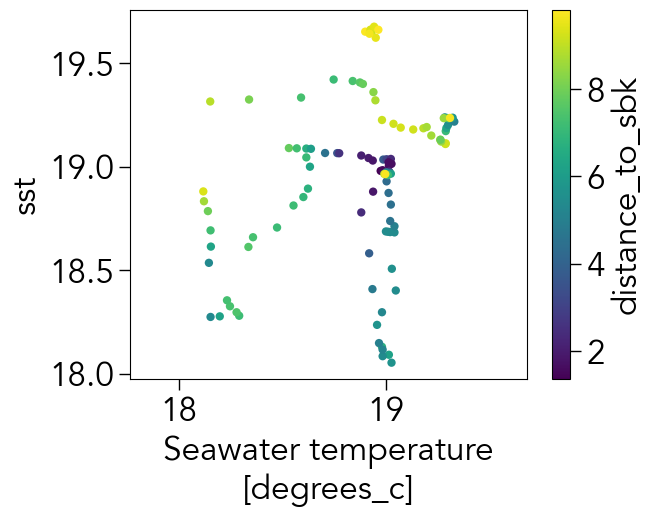

In [33]:
wgsb.where(wgsb.distance_to_sbk < 10).plot.scatter(x='sst_sbk', y='sst', hue='distance_to_sbk', ec=None)
plt.axis('equal')

(35.22105439494466, 35.60566203773119, 35.447065614746876, 35.90101682561073)

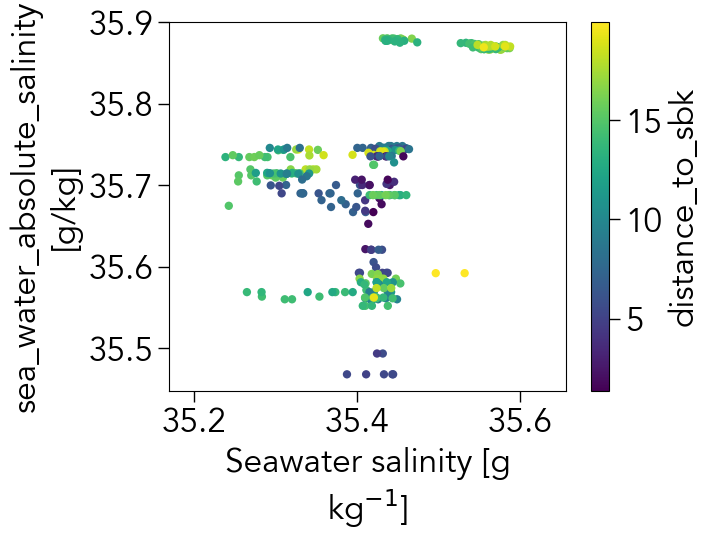

In [59]:
wgsb.where(wgsb.distance_to_sbk < 20).plot.scatter(x='sss_sbk', y='sss', hue='distance_to_sbk', ec=None)
plt.axis('equal')

In [54]:
wg['sss'] = gsw.SA_from_SP(gsw.SP_from_C(wg['ssc']*10,wg['sst'],0),0,wg['longitude'],wg['latitude'])

In [55]:
wg['sss'] = wg['sss'].rolling(time=21,center=True).median('time')

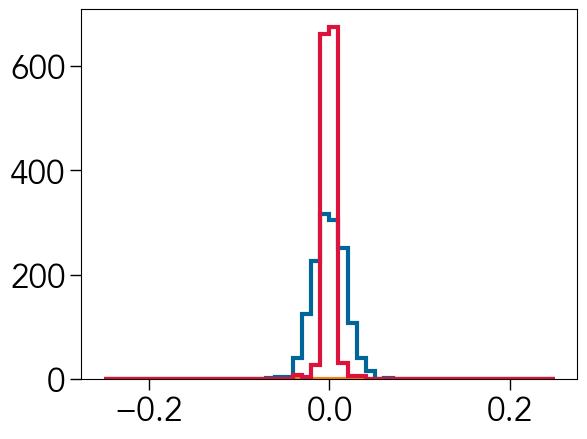

In [69]:
_=plt.hist(wg.sel(time=slice('2023-03-23','2023-04-01'))['sss'].diff('time'),ec=wgc, histtype='step', lw=3, bins=np.arange(-0.25,0.26,0.01))
_=plt.hist(sbk.sel(time=slice('2023-03-23','2023-04-01'))['sss'].diff('time'),ec=kc, histtype='step', lw=3, bins=np.arange(-0.25,0.26,0.01))
_=plt.hist(sbpp.sel(time=slice('2023-03-23','2023-04-01'))['sss'].diff('time'),ec=ppc, histtype='step', lw=3, bins=np.arange(-0.25,0.26,0.01))

In [77]:
import cartopy.crs as ccrs

In [117]:
sbk.isel(time=slice(0,-1,6))

<xarray.Dataset>
Dimensions:           (time: 1410)
Coordinates:
  * time              (time) datetime64[ns] 2023-03-06T11:20:00 ... 2023-05-0...
    doy               (time) float64 ...
    mday              (time) float64 ...
Data variables: (12/33)
    latitude          (time) float64 -37.16 -37.15 -37.13 ... -33.34 -33.33
    longitude         (time) float64 ...
    ttff              (time) float64 ...
    count             (time) float64 ...
    commands          (time) float64 ...
    tries             (time) float64 ...
    ...                ...
    t2m               (time) float64 18.06 18.49 17.35 ... 14.2 14.15 14.81
    u10               (time) float64 5.002 7.626 9.655 ... 4.229 3.808 2.278
    flags             (time) object 'n' 'n' 'n' 'n' 'n' ... 'n' 'n' 'n' 'n' 'n'
    distance_to_wg    (time) float64 nan 4.786 7.371 10.45 ... nan nan nan nan
    distance_to_pp    (time) float64 nan nan nan nan ... 497.1 500.1 501.3 503.7
    distance_to_ship  (time) float64 0.3829 4.48 7.6 11.2 ... nan nan nan nan
Attributes: (12/24)
    title:                SB Kringla Datalogger
    summary:              Datalogger output from Sailbuoy Kringla
    conventions:          CF-1.6, ACDD-1.3
    creator_name:         Johan Edholm
    platform:             Uncrewed surface vehicle
    instrument_name:      Kringla
    ...                   ...
    time_coverate_start:  2023-02-21T13:43:11.000000000
    time_coverate_end:    2023-05-04T11:50:00.000000000
    geospatial_lat_min:   -37.933327
    geospatial_lat_max:   -33.321951
    geospatial_lon_min:   16.049747
    geospatial_lon_max:   19.96224

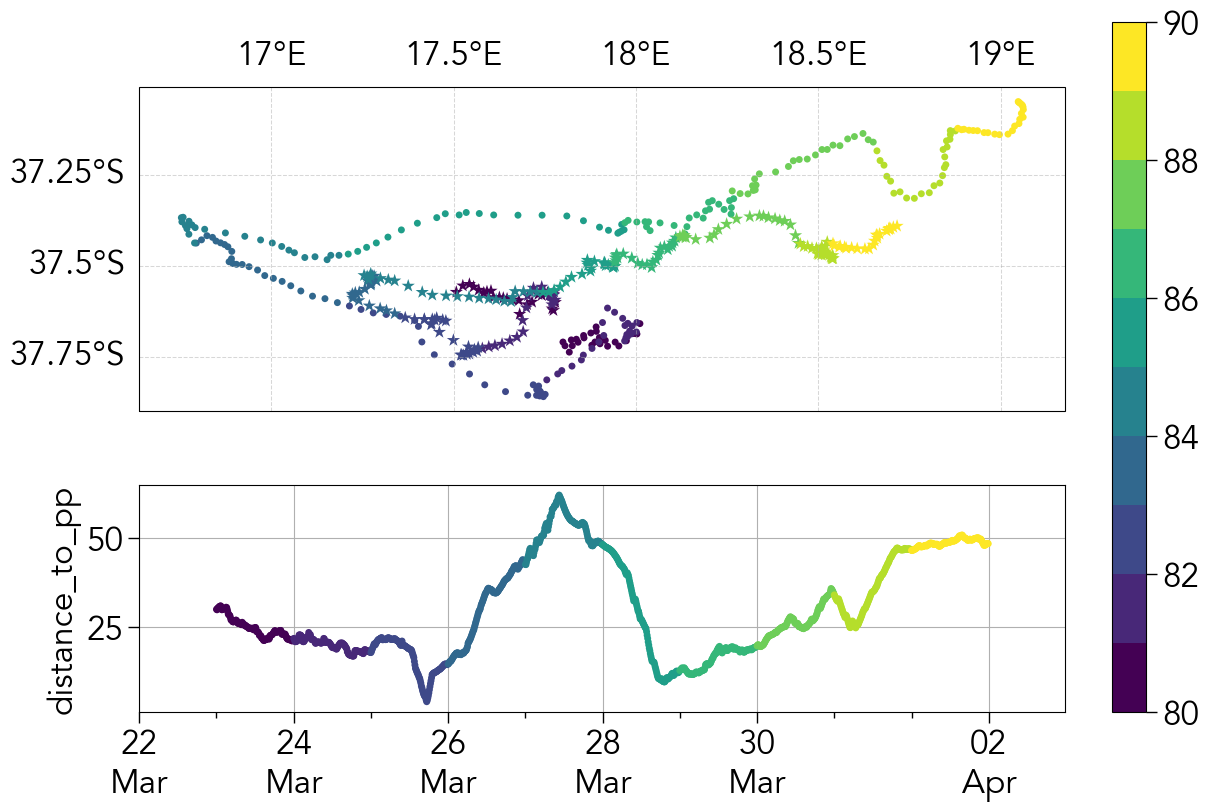

In [136]:
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(nrows=3, ncols=1)
ax = fig.add_subplot(gs[2, :])
bx = fig.add_subplot(gs[0:2, :], projection=ccrs.PlateCarree())

cmap=plt.get_cmap('viridis',10)
vmin=80
vmax=90
sbk.sel(time=slice('2023-03-23','2023-04-01')).plot.scatter(x='time',y='distance_to_pp',ax=ax,hue='doy', add_colorbar=False, ec=None, s=100, zorder=2, cmap=cmap,marker='.', vmin=vmin, vmax=vmax)
ax.grid(zorder=1)

for sb, sbm in zip([sbk,sbpp],['.','*']):
    sct = sb.sel(time=slice('2023-03-23','2023-04-01')).isel(time=slice(0,-1,6)).plot.scatter(x='longitude', y='latitude',ec=None, s=100,marker=sbm, lw=0.25, hue='doy', add_colorbar=False, ax=bx, zorder=2, cmap=cmap, vmin=vmin, vmax=vmax)

# bx.gridlines(color='lightgrey', linestyle='-', draw_labels=True, zorder=1)
gridlines(bx,0.5,0.25,True,False,True,False)

fix_xticks([ax],sbk.sel(time=slice('2023-03-23','2023-04-01')))
plt.colorbar(sct,ax=[bx,ax])


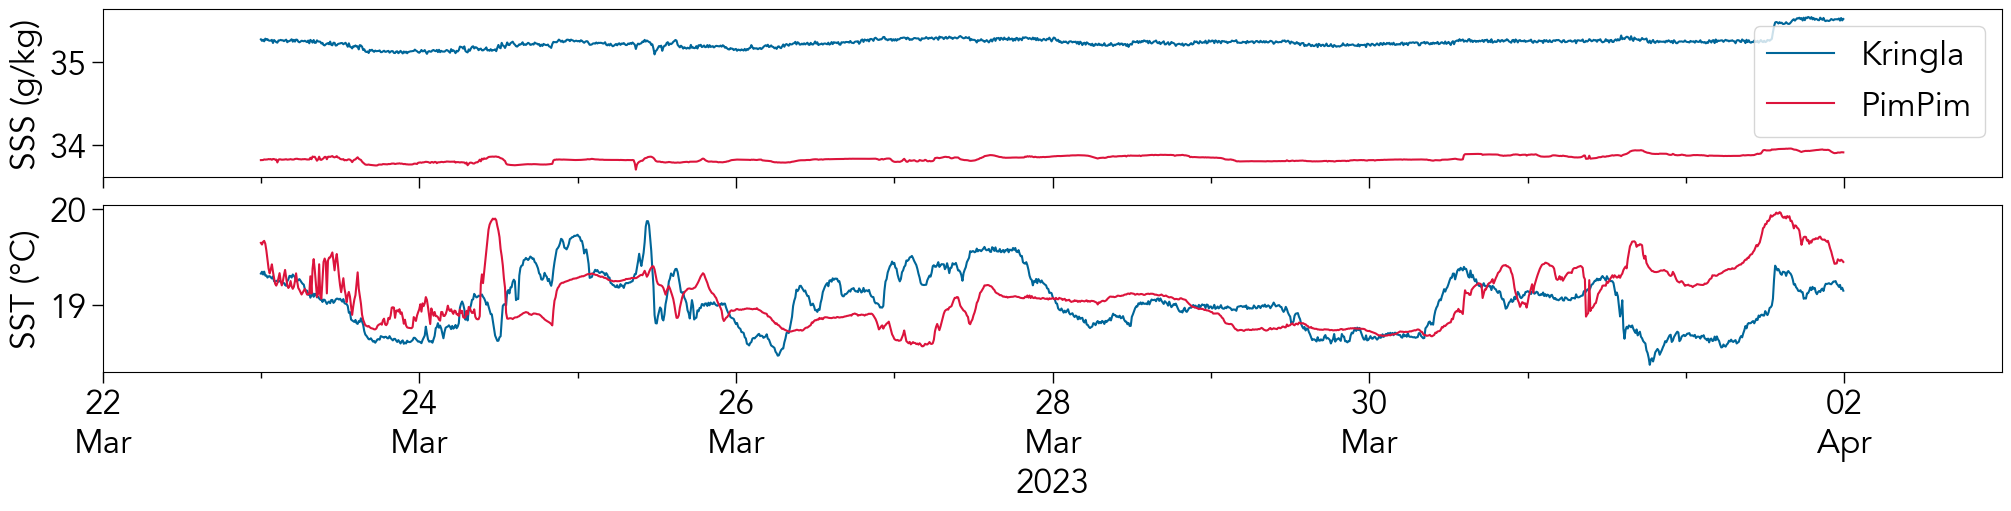

In [148]:
fig,ax = plt.subplots(2,1,figsize=(20,5),constrained_layout=True, sharex=True)

for axs,var,l in zip(ax,['sss','sst'],['SSS (g/kg)','SST (°C)']):
    for sb,sbc,label in zip([sbk,sbpp],[kc,ppc],['Kringla','PimPim']):
        sb.sel(time=slice('2023-03-23','2023-04-01'))[var].plot(c=sbc,ax=axs,label=label)
    axs.set(xlabel='',ylabel=l)
ax[0].legend()

fix_xticks(ax,sb.sel(time=slice('2023-03-23','2023-04-01')))

## 3. Plot the result

In [280]:
def plot_met_variables(ship, sbk, sbpp, sbpp1, wg, sc, kc, ppc, wgc):
    """
    Plot corrected meteorological variables for different datasets.

    Parameters:
        ship (xarray.Dataset): Meteorological variables for ship data.
        sbk (xarray.Dataset): Meteorological variables for Kringla data.
        sbpp (xarray.Dataset): Meteorological variables for PimPim data.
        sbpp1 (xarray.Dataset): Additional PimPim data for comparison.
        sc (str): Color for Ship data.
        kc (str): Color for Kringla data.
        ppc (str): Color for PimPim data.

    Returns:
        None
    """

    # Labels for different datasets
    labels = ['Ship', 'Kringla', 'PimPim', 'PimPim1', 'WaveGlider']

    # Colors for different datasets
    colors = [sc, kc, ppc, ppc, wgc]

    # List of datasets
    datasets = [ship, sbk, sbpp, sbpp1, wg]

    # Create subplots
    fig, ax = plt.subplots(3, 1, figsize=(30, 12), constrained_layout=True, sharex=True)

    # Inside the loop where you're selecting the appropriate variable data for plotting
    for i in range(len(ax)):
        for j in range(len(labels)):
            # Skip plotting for specific cases
            if i == 2 and (j == 1 or j == 4):
                continue

            # Check if the variable exists in the dataset
            variable_name = ['t2m', 'u10', 'q2m'][i]
            if variable_name in datasets[j]:
                plot_data = datasets[j][variable_name]

                # Plot the data with labels and colors
                if j == 3:
                    # Don't include sbpp1 in legend
                    plot_data.plot(ax=ax[i], label='_nolegend_', c=colors[j])
                else:
                    plot_data.plot(ax=ax[i], label=labels[j], c=colors[j])
            else:
                # Handle the case where the variable doesn't exist in the dataset
                print(f"Warning: {variable_name} not found in dataset {labels[j]}")

        # Set legend and y-axis label for each subplot
        ax[i].legend(ncol=2, fontsize=16)
        ax[i].set_ylabel(['(°C)', '(m s$^{-1}$)', '(g kg$^{-1}$)'][i])
        ax[i].set_xlabel('')  # Clear x-axis label
        ax[i].set_title(['2-m temperature', '10-m wind speed', '2-m specific humidity'][i], loc='left')

    # Set the title for the first subplot
    ax[0].set_title('Corrected met variables')

    # Call the fix_xticks function for formatting x-axis ticks
    ax[-1].set_xlim(ship.time[0],ship.time[-1])
    fix_xticks(ax, ship)
    
    # Show the plot
    plt.show()


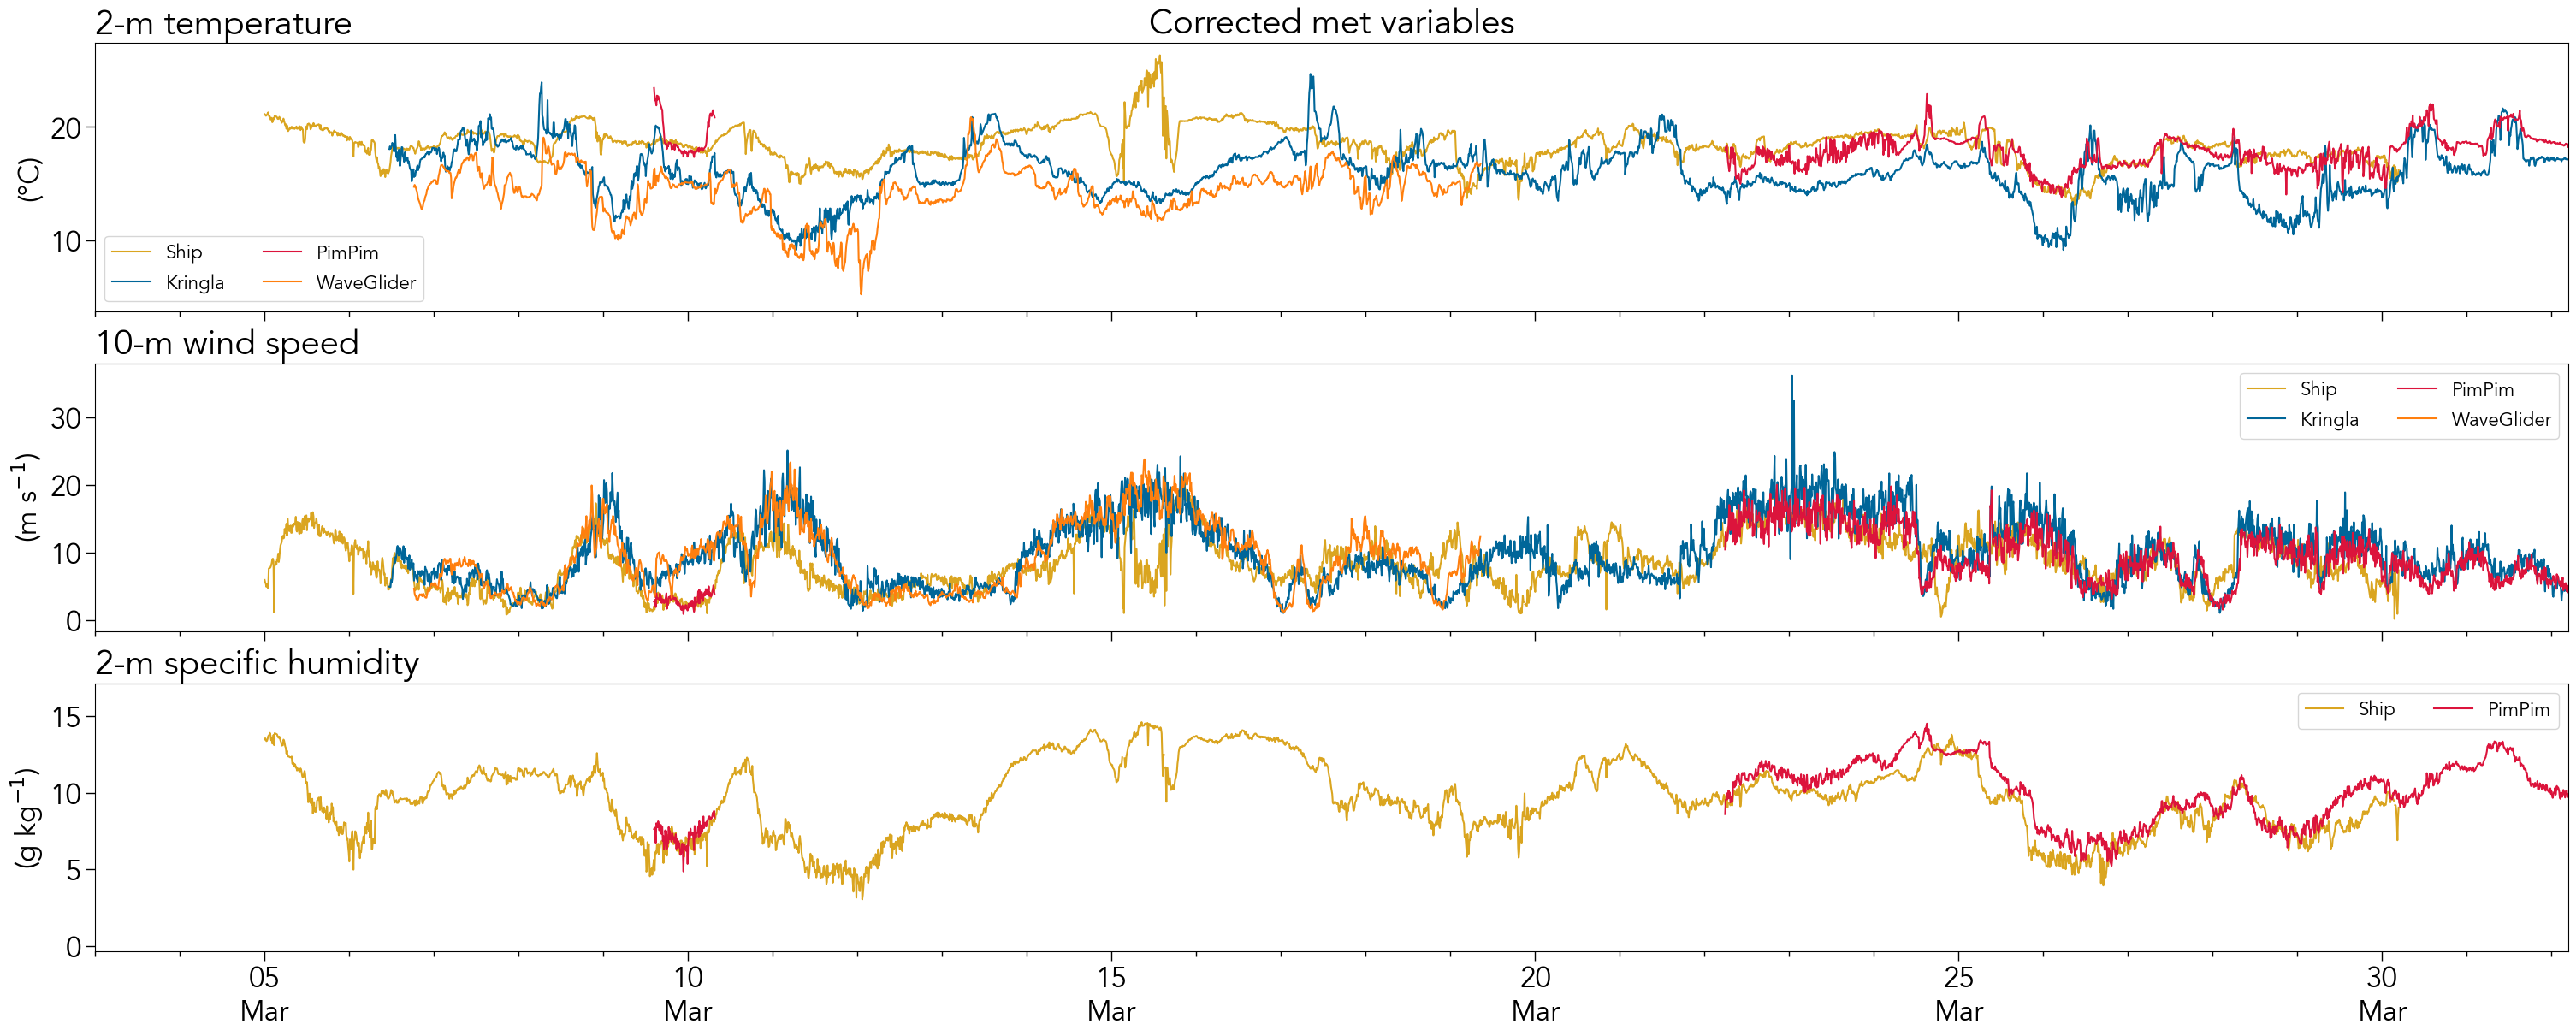

In [295]:
plot_met_variables(ship, sbk, sbpp, sbpp1, wg, sc, kc, ppc, 'C1')

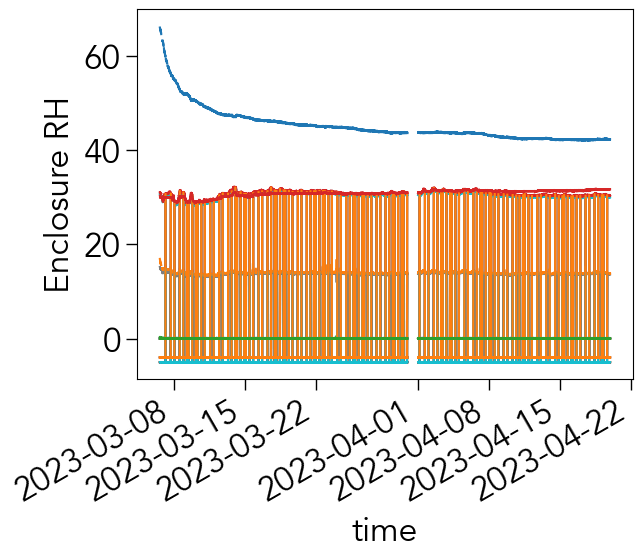

In [301]:
for key in list(ds.keys()):
    if 'RH' in key:
        ds[key].plot()

## Save the result

In [173]:
sbpp = xr.merge([sbpp1,sbpp])

In [174]:
sbk.to_netcdf('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/kringla_quicche_corrected.nc')
sbpp.to_netcdf('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/pimpim_quicche_full_corrected.nc')
ship.to_netcdf('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche_corrected.nc')

## Correct for flow field distortion by the ship

In [18]:
ship = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche_corrected.nc')

In [19]:
era5 = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/ERA5_QUICCHE.nc').mean('expver',keep_attrs=True)

era5['t2m'].values = era5['t2m'].values - 273.15
era5['sst'].values = era5['sst'].values - 273.15
era5['skt'].values = era5['skt'].values - 273.15

In [20]:
def angle_diff(ds,var1,var2):
    return np.angle(np.exp(1j * np.deg2rad(ds[var1])) / np.exp(1j * np.deg2rad(ds[var2].values)), deg=True)

In [21]:
ship['doy'] = xr.DataArray(mdates.date2num(ship['time']) - mdates.date2num(np.datetime64('2023-01-02')),dims='time')
ship = ship.set_coords('doy')
ship['hrw'] = ('time'),angle_diff(ship,'SH','TI')

In [22]:
mt = [time for time in ship.time.values if time in np.unique(ship.time.dt.floor('H').values)]
mi = [np.where(ship.time.values == time)[0][0] for time in mt]
ship_1h = ship.isel(time=mi)



In [23]:
########## Ship ##########
t = ship_1h.time.values

lats = (np.round(ship_1h['LA'].interpolate_na('time') * 4) / 4)
lons = (np.round(ship_1h['LO'].interpolate_na('time') * 4) / 4)

   
temp = []
for i in range(len(t)):
    temp.append(era5.sel(time=t[i]).sel(longitude=lons[i]).sel(latitude=lats[i]))
    
era5_ship = xr.concat(temp,dim='time')
era5_ship['wind_speed'] = np.sqrt(era5_ship['u10']**2 + era5_ship['v10']**2)
era5_ship['wind_dir'] = ('time'), ((np.arctan2(era5_ship['u10'],era5_ship['v10']) * 180 / np.pi + 180) % 360).values
era5_ship['doy'] = ship_1h['doy']
era5_ship = era5_ship.set_coords('doy')

ship_1h['hrw_era'] = ('time'),-np.angle(np.exp(1j * np.deg2rad(ship_1h['SH'])) / np.exp(1j * np.deg2rad(era5_ship['wind_dir'].values)), deg=True)

In [24]:
ship_1h = ship_1h.drop('flags').interpolate_na('time')

<span style='font-size: 20px;'>We lose 21.7% of the data</span>

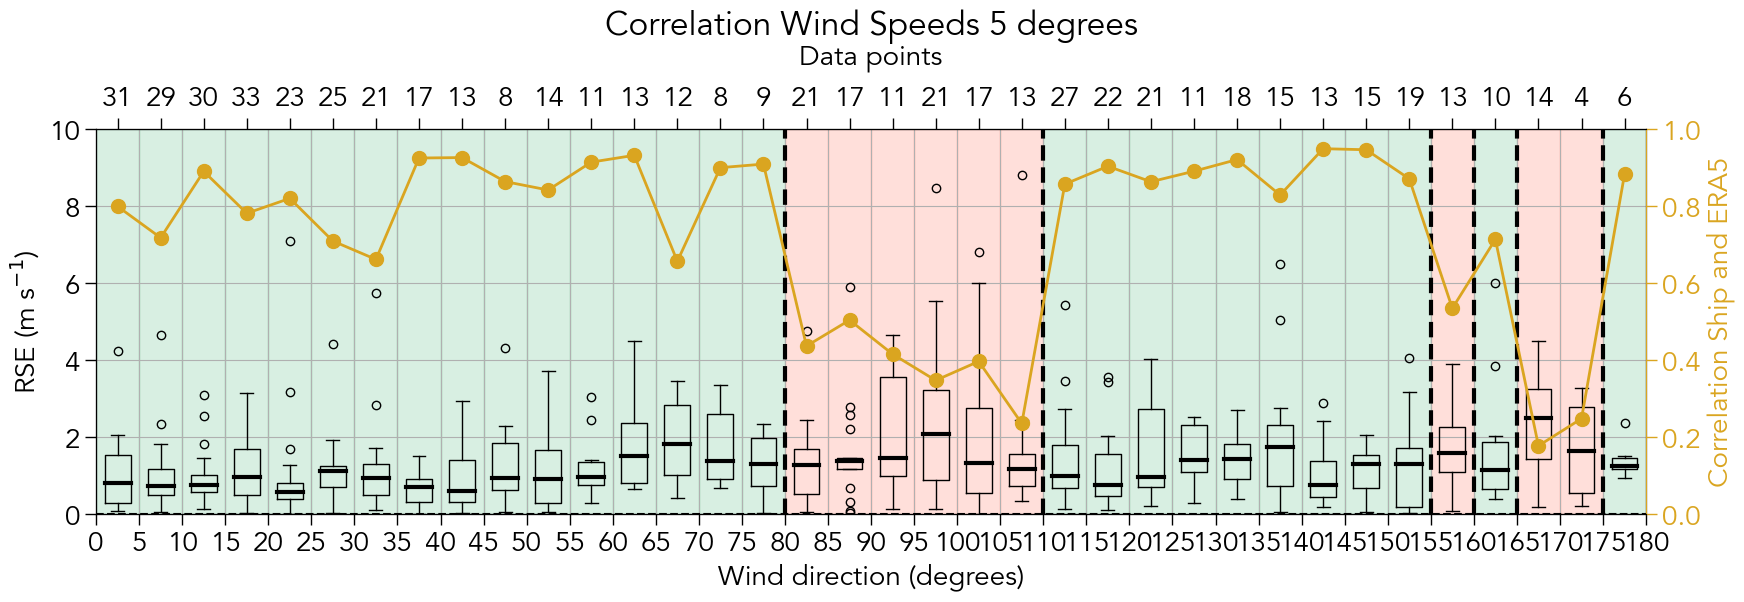

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 5
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = (np.abs(ship_1h['hrw_era']) > i) & (np.abs(ship_1h['hrw_era']) < i + da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.6

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < 0.6:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()

print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

<span style='font-size: 20px;'>We lose 20.5% of the data</span>

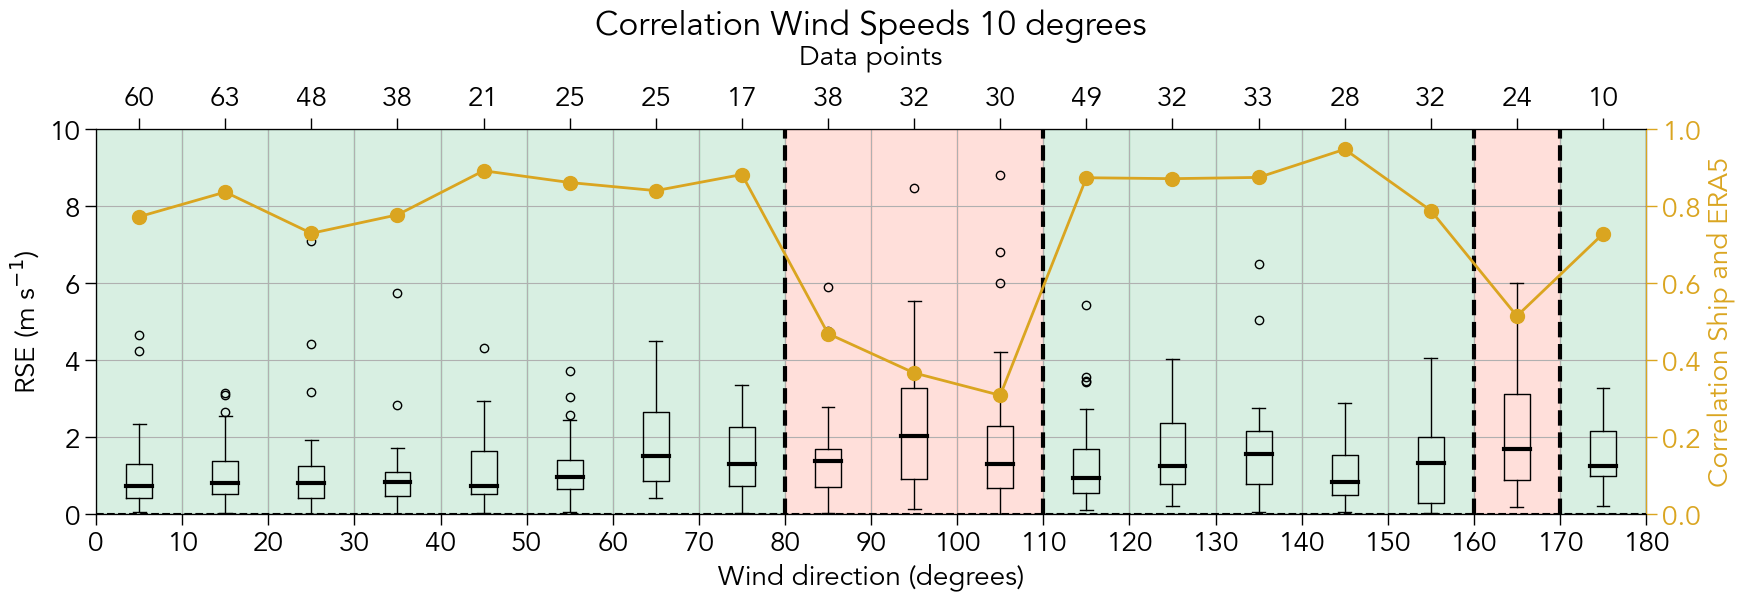

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 10
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = (np.abs(ship_1h['hrw_era']) > i) & (np.abs(ship_1h['hrw_era']) < i + da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.6

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < 0.6:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()
print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

<span style='font-size: 20px;'>We lose 19.8% of the data</span>

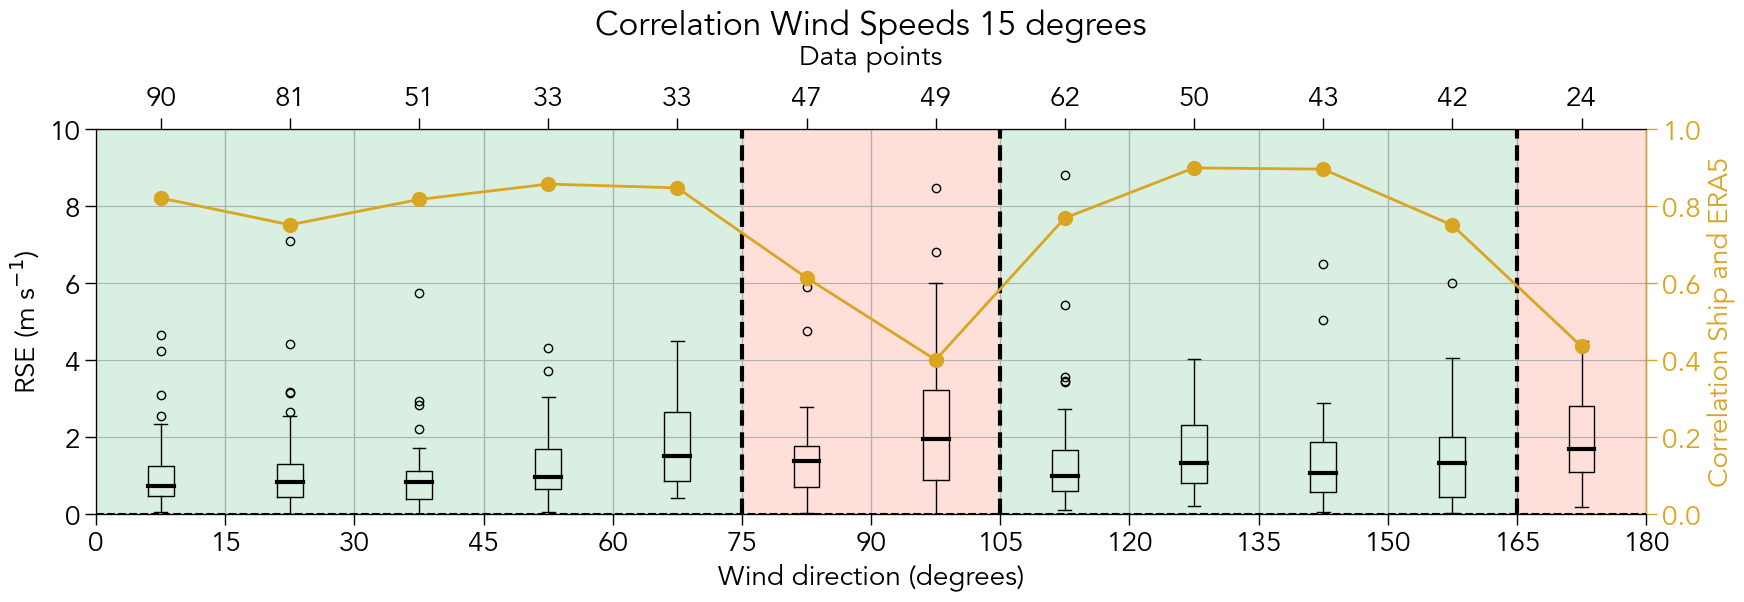

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 15
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = (np.abs(ship_1h['hrw_era']) > i) & (np.abs(ship_1h['hrw_era']) < i + da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.7

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < lim:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()

print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

<span style='font-size: 20px;'>We lose 17.5% of the data</span>

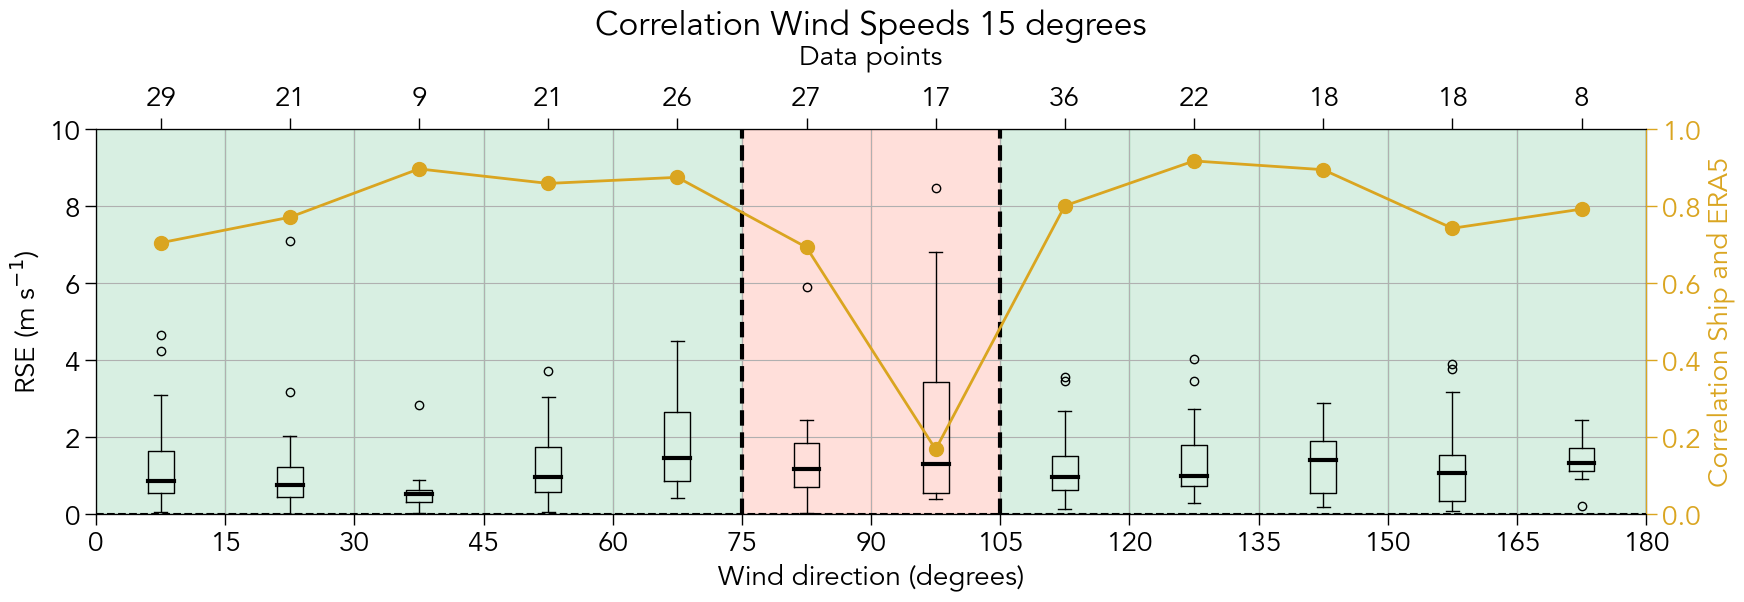

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 15
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = ((ship_1h['hrw_era']) > i) & ((ship_1h['hrw_era']) < i + da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.7

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < lim:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()

print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

<span style='font-size: 20px;'>We lose 19.3% of the data</span>

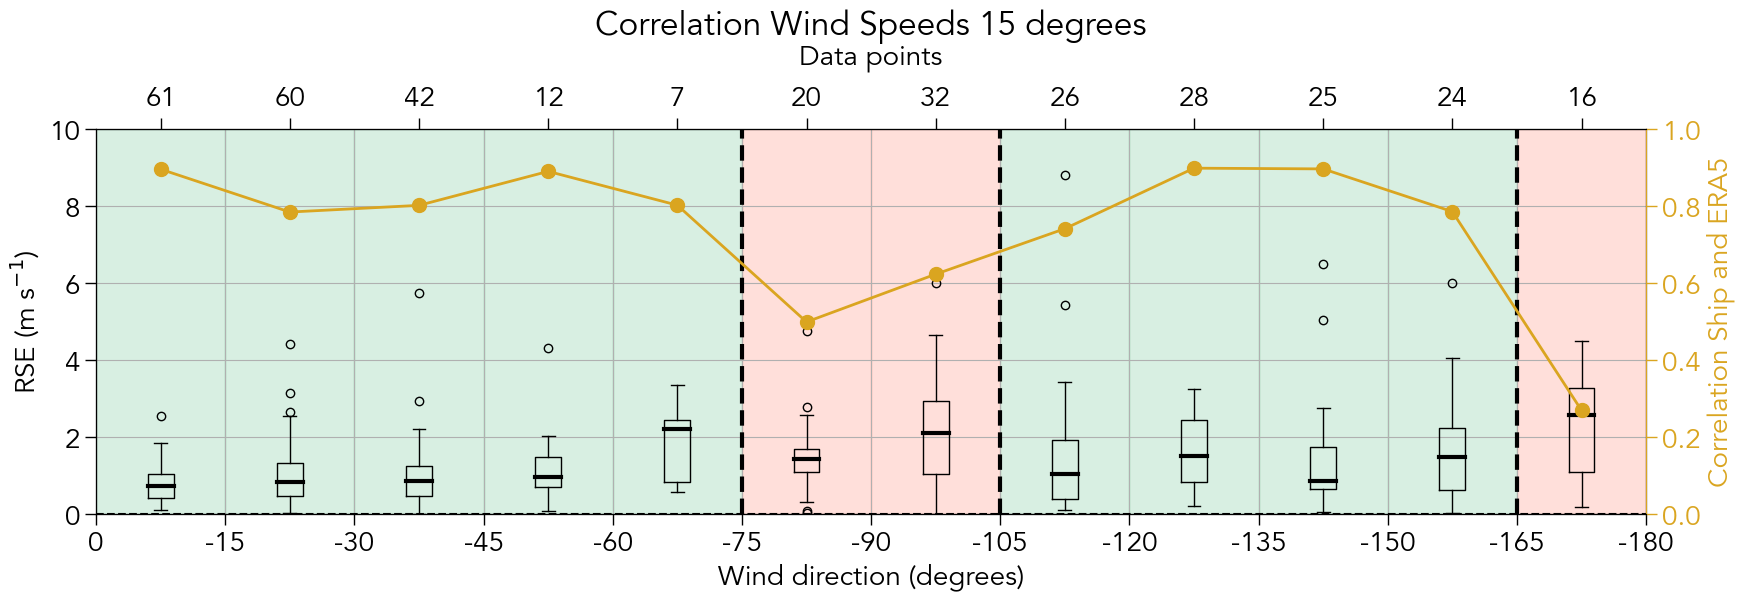

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 15
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = ((ship_1h['hrw_era']) < -i) & ((ship_1h['hrw_era']) > -i - da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(-x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.7

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < lim:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()

print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

In [168]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

<Figure size 640x480 with 0 Axes>

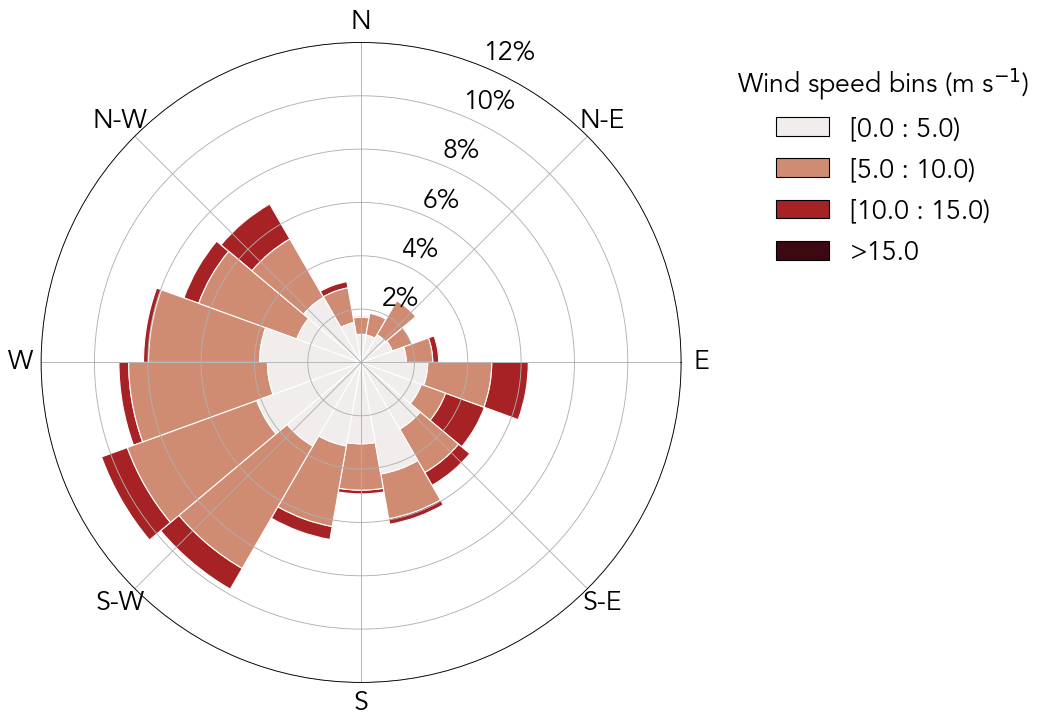

In [14]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import numpy as np

# Create a new figure
fig = plt.figure()

# Define a rectangular region (left, bottom, width, height) for the plot
rect = [0.1, 0.1, 0.8, 0.8]
# Create an axes (plotting area) within the figure using the defined rectangular region
hist_ax = plt.Axes(fig, rect)
# Create a dummy bar plot in the axes (this is just a placeholder, not relevant to wind rose)
hist_ax.bar(np.array([1]), np.array([1]))
# Note: The dummy bar plot above is created before the windrose plot to ensure curved sectors in the wind rose.

# Create a WindroseAxes object based on the previously created axes
ax = WindroseAxes.from_ax(figsize=(10,10))

# Plot a wind rose on the WindroseAxes object
ax.bar(
    sbk['wind_dir'],            # Wind direction data
    sbk['wind_speed'],          # Wind speed data
    normed=True,                # Normalize the data
    opening=1,                  # Angle of the sector opening (1 means that the bar covers the whole bin. Decrease this number for more white space between each bar)
    edgecolor='white',          # Color of sector edges
    nsector=18,                 # Number of sectors in the wind rose
    bins=np.arange(0, 20, 5),   # Bins for the wind speed data
    cmap=cmo.amp                # Colormap for coloring sectors
)

# Add a legend to the wind rose plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, title = 'Wind speed bins (m s$^{-1}$)', title_fontsize=24)

# Set custom r-axis ticks and labels
custom_r_ticks = [2, 4, 6, 8, 10, 12]  # Adjust these values as needed
custom_r_labels = [str(tick) + '%' for tick in custom_r_ticks]  # Labels corresponding to the ticks

# Apply the custom ticks and labels to the r-axis
ax.set_yticks(custom_r_ticks)
ax.set_yticklabels(custom_r_labels)

# Display the wind rose plot
plt.show()

In [18]:
from scipy import stats

# Interval for binning the data
da = 15
R = []  # List to store the correlation coefficients
rmse = []
rstdse = []

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in np.arange(-180, 180, da):
    # Create a mask to select data within the current interval
    mask  = ((ship_1h['hrw_era']) > i) & ((ship_1h['hrw_era']) < i + da)
    
    # Apply the mask to select the relevant data for the boxplot
    rmse.append(np.sqrt(np.mean(np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed']))))
    rstdse.append(np.sqrt(np.std(np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed']))))
    
    # Calculate the correlation coefficient
    R.append(stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed']).rvalue ** 2)
    
rmse = np.array(rmse)

In [64]:
from scipy import stats
import numpy as np
from matplotlib.cm import ScalarMappable

def calculate_interval_statistics(ship_1h, era5_ship, interval_size=15):
    """
    Calculate interval statistics including RMSE, root standard error of RMSE, and correlation coefficients.

    This function calculates various statistics within specified intervals for two datasets.

    Args:
        ship_1h (pd.DataFrame): DataFrame containing ship data.
        era5_ship (pd.DataFrame): DataFrame containing ERA5 ship data.
        interval_size (int, optional): Size of each interval for data binning. Default is 15.

    Returns:
        tuple: A tuple containing three lists - RMSE (Root Mean Square Error),
               root_std_err (Root Standard Error), and correlation coefficients.
    """

    R = []          # List to store the correlation coefficients
    p = []          # List to store the correlation coefficients
    rmse = []       # List to store the Root Mean Square Errors
    rstdse = []     # List to store the root standard error of RMSE
    n = []
    
    # Iterate over the interval of -180 to 180 (inclusive) with step size interval_size
    for i in np.arange(-180, 180, interval_size):
        # Create a mask to select data within the current interval
        mask = ((ship_1h['hrw_era']) > i) & ((ship_1h['hrw_era']) < i + interval_size)

        # Apply the mask to select the relevant data for RMSE calculation
        rmse_diff = ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed']
        rmse.append(np.sqrt(np.mean(np.square(rmse_diff))))

        # Calculate the root standard error of RMSE
        rstdse.append(np.sqrt(np.std(np.square(rmse_diff))) / np.sqrt(mask.values.sum()))

        # Calculate the correlation coefficient and store its squared value
        corr_coeff = stats.linregress(ship_1h.where(mask, drop=True)['u10'],
                                      era5_ship.where(mask, drop=True)['wind_speed']).rvalue ** 2
        R.append(corr_coeff)
        
        # Calculate the correlation coefficient and store its squared value
        corr_coeff = stats.linregress(ship_1h.where(mask, drop=True)['u10'],
                                      era5_ship.where(mask, drop=True)['wind_speed']).pvalue
        p.append(corr_coeff)
        
        n.append(mask.values.sum())
        
    rmse = np.array(rmse)
    rstdse = np.array(rstdse)
    n = np.array(n)
    R = np.array(R)
    
    # Create a figure with polar projection
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, facecolor=None, constrained_layout=True, figsize=(12,8))

    # Set 0 at the top (North) and rotate clockwise
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)

    # Plot bars and errorbars with a colormap based on R values
    bars = ax.bar(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)), rmse, width=np.deg2rad(interval_size), bottom=0, edgecolor='none')

    # Apply the cmo.amp colormap to the bars based on the R values
    for bar, r_value in zip(bars, R):
        bar.set_facecolor(cmo.matter(r_value))

    # Add errorbars
    ax.errorbar(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)), rmse, yerr=rstdse, lw=1, fmt="o", c='0.35', markersize=4)
    
    ax.plot(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)), n/30, c='gold', lw=3, zorder=5)
    
    # Adjust radial tick labels
    ax.set_rlabel_position(-22.5)

    # Create a scalar mappable for colorbar
    sm = ScalarMappable(cmap=cmo.matter)
    sm.set_array([])

    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, fraction = 0.02, aspect = 20)
    cbar.set_label('Correlation (R$^2$)', rotation=270, labelpad=25)

    ax.scatter(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)),np.array(p)*10, c='r', ec='w', zorder=3)
    
    # Add a circle at r=0.5
    ax.plot(np.deg2rad(np.arange(0,360,0.1)), [0.5]*3600, c='red', lw=2, ls='--', zorder=4)

    # Show the plot
    plt.show()

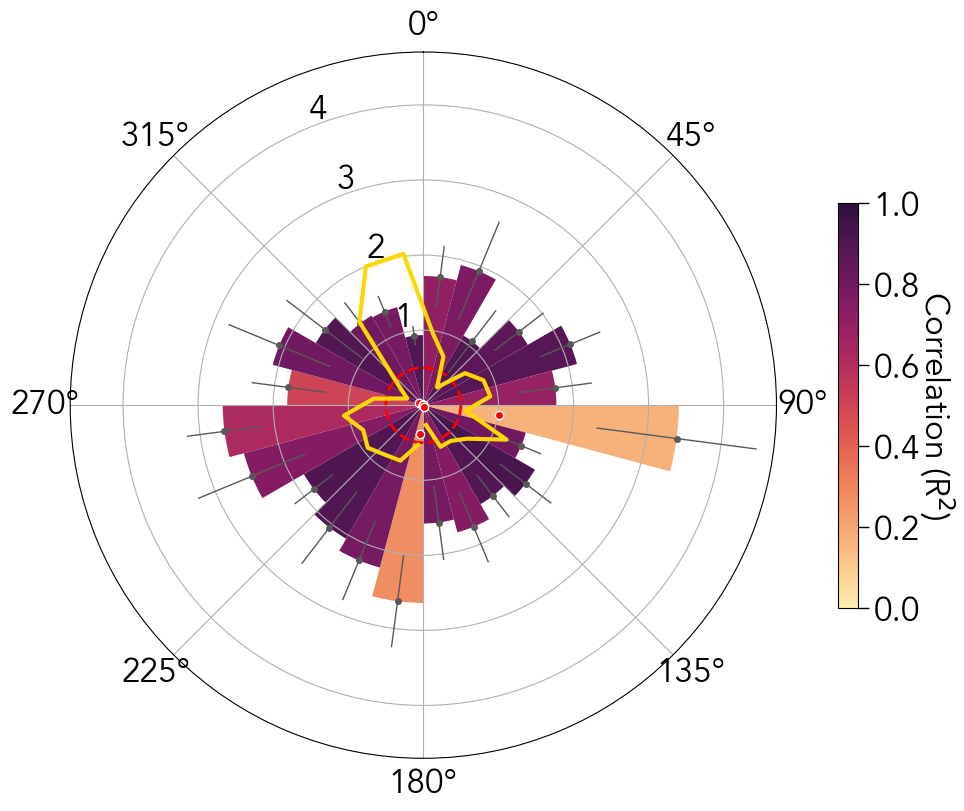

In [65]:
p = calculate_interval_statistics(ship_1h, era5_ship, interval_size=15)

So, we need to mask values when `90 < HRW_ERA < 105`, maybe even `180 < HRW_ERA < 195`.

In [262]:
mask = np.logical_and(~np.logical_and(ship_1h['hrw_era'] > 90,   ship_1h['hrw_era'] < 105), 
                      ~np.logical_and(ship_1h['hrw_era'] < -165, ship_1h['hrw_era'] > -180)).values

In [263]:
ship = ship.set_coords(['LA','LO']).isel(time=slice(0,-2)).where(np.repeat(mask,6)[3:])

In [264]:
ship.to_netcdf('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche_corrected_wind_binned.nc')

In [177]:
(((6371**3 - (6371-3.5)**3) * np.pi * 14/15)/(14/15*np.pi))**(1/3)

752.4112847073874

<xarray.Dataset>
Dimensions:  (time: 3627)
Coordinates:
  * time     (time) datetime64[ns] 2023-03-05 ... 2023-03-30T04:20:00
    LA       (time) float64 ...
    LO       (time) float64 ...
    doy      (time) float64 62.0 62.01 62.01 62.02 ... 87.16 87.17 87.17 87.18
Data variables: (12/104)
    Time     (time) float64 14.5 1.014e+03 2.014e+03 ... 4.101e+04 4.201e+04
    AT       (time) float64 21.36 21.27 21.26 21.36 ... 16.69 16.76 16.66 16.56
    BP       (time) float64 1.008e+03 1.008e+03 ... 1.018e+03 1.018e+03
    BS       (time) float64 1.01e+03 1.01e+03 1.01e+03 ... 1.02e+03 1.02e+03
    PR       (time) float64 29.5 29.51 29.51 29.51 ... 49.85 49.81 49.81 49.87
    RH       (time) float64 86.9 87.79 87.92 87.41 ... 80.02 79.7 80.07 80.4
    ...       ...
    SX       (time) float64 0.283 0.6103 0.5457 0.4147 ... -99.0 -99.0 -99.0
    hrw      (time) float64 111.4 100.9 115.1 112.1 ... -59.29 -8.994 134.0
    t2m      (time) float64 21.12 21.08 20.98 21.01 ... 16.27 16.22 15.69 15.15
    u10      (time) float64 5.99 5.607 5.434 4.984 ... 5.981 4.394 2.35 0.9758
    q2m      (time) float64 13.47 13.55 13.45 13.36 ... 9.176 8.83 8.123 6.895
    flags    (time) object 'n' 'n' 'n' 'n' 'n' 'n' ... 'l' 'n' 'n' 'n' 'n' 'l'